In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def lerarquivos(mes):
     #Caminho do arquivo CSV
    url = f"../dados-tratados/pc-{mes:0>2}.csv"

    # Carregando o dataset
    return pd.read_csv(url, sep=";")


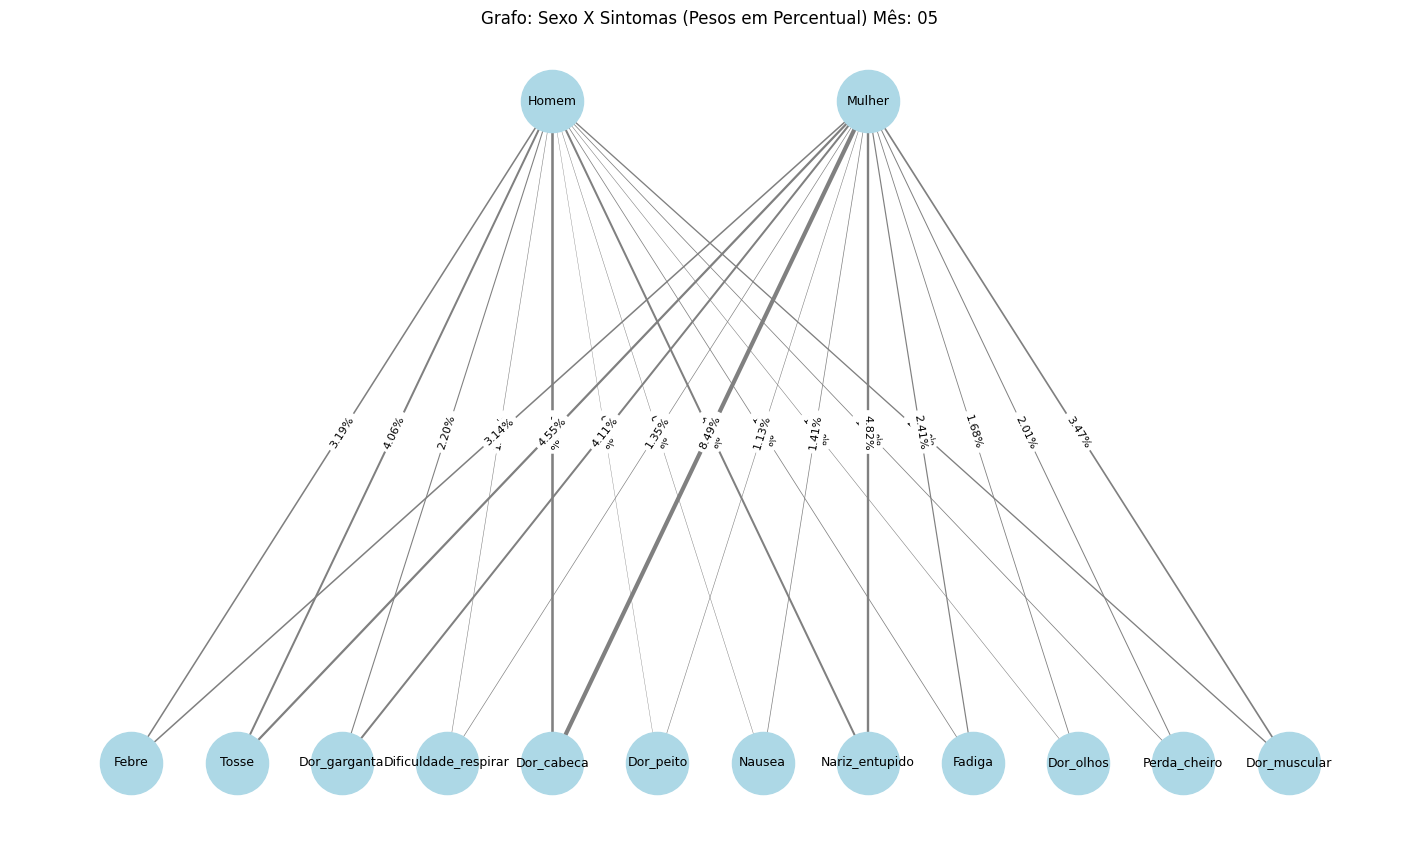

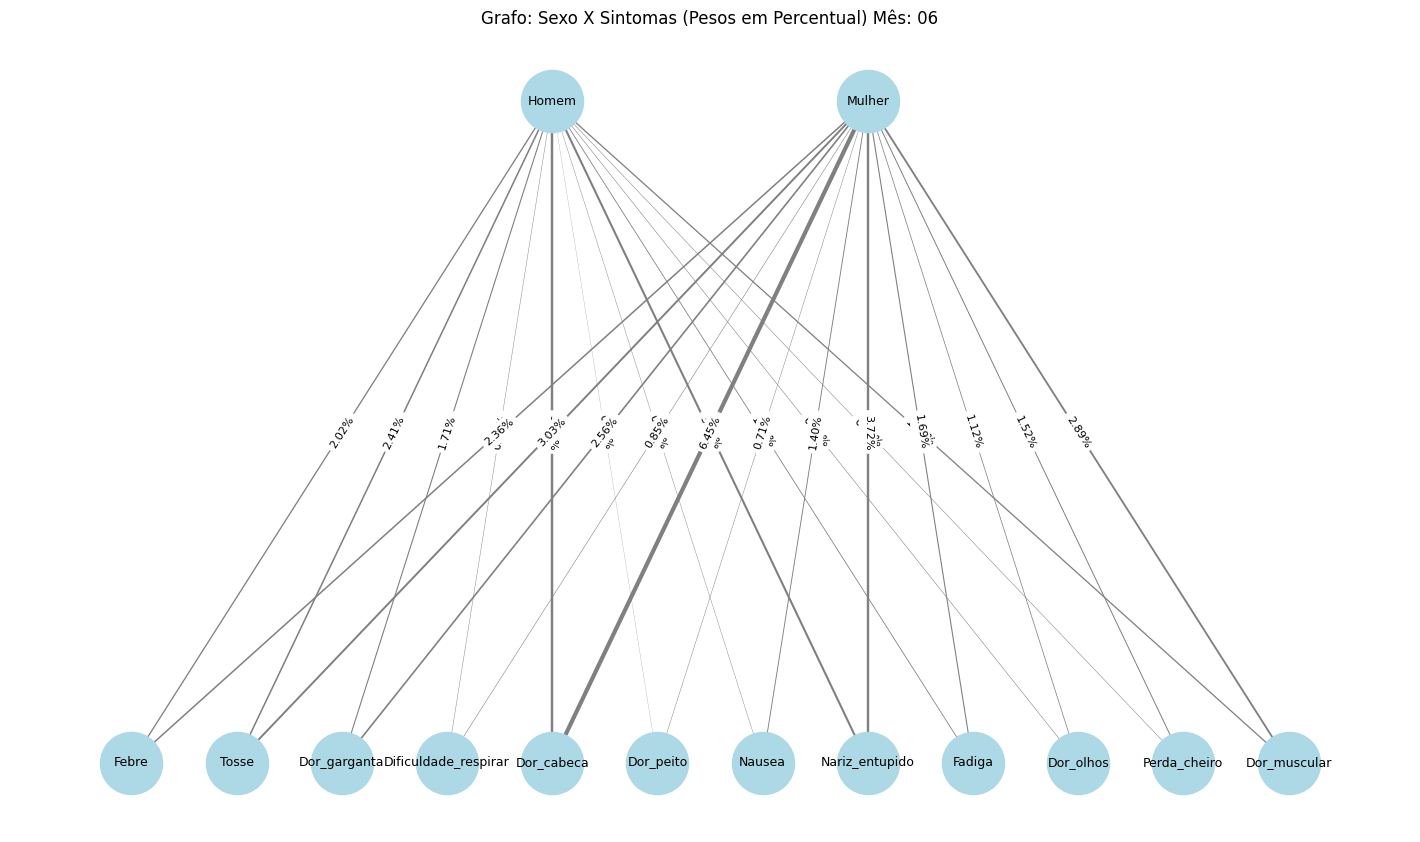

In [6]:
# Definindo os sexos e sintomas
sexos = [
    "Homem", "Mulher"
]
colunas_sintomas = [
    "Febre", "Tosse", "Dor_garganta", "Dificuldade_respirar",
    "Dor_cabeca", "Dor_peito", "Nausea", "Nariz_entupido",
    "Fadiga", "Dor_olhos", "Perda_cheiro", "Dor_muscular"
]

# Loop para os meses (ajuste conforme necessário)
for m in range(5, 7):
    df = lerarquivos(m)

    # Preenchendo NaN na coluna de Sexo e filtrando os sexos
    sexo_coluna = "Sexo"
    df[sexo_coluna] = df[sexo_coluna].fillna("Ignorado")  # Evitar erro com NaN
    df = df[df[sexo_coluna].isin(sexos)]  # Filtrando os sexos

    # Criando o grafo
    G = nx.Graph()

    # Adicionando os nós de sexo à parte superior e sintomas à parte inferior
    G.add_nodes_from(sexos, bipartite=0)  # Sexo na parte superior
    G.add_nodes_from(colunas_sintomas, bipartite=1)  # Sintomas na parte inferior
    
    

    # Contagem de pessoas por sexo
    total_por_sexo = df[sexo_coluna].value_counts().to_dict()

    # Calculando as arestas entre sexo e sintomas
    pesos = {}

    for _, row in df.iterrows():
        sexo = row[sexo_coluna]
        for sintoma in colunas_sintomas:
            if row[sintoma] == "Sim":  # Considerando "Sim" como presença do sintoma
                peso = 1  # A cada "Sim", adiciona 1

                # Se a aresta já existe, soma o peso
                if (sexo, sintoma) in pesos:
                    pesos[(sexo, sintoma)] += peso
                else:
                    pesos[(sexo, sintoma)] = peso

    # Calculando os pesos percentuais das arestas em relação à quantidade de pessoas no sexo
    pesos_percentuais = {
        (u, v): (peso / total_por_sexo[u]) * 100 for (u, v), peso in pesos.items()
    }

    # Adicionando as arestas ao grafo com os pesos em percentual
    for (u, v), peso in pesos_percentuais.items():
        G.add_edge(u, v, weight=peso)

    # Definindo a posição dos nós (sexos na parte superior, sintomas na parte inferior)
    pos = {}

    # Posicionando os sexos na parte superior com espaçamento uniforme
    sexo_x = np.linspace(4,7, len(sexos))  # Ajuste para posicionar mais à direita
    for i, (sexo, x) in enumerate(zip(sexos, sexo_x)):
        pos[sexo] = (x, 1)  # Sexos na parte superior, mais para a direita

    # Posicionando os sintomas na parte inferior com espaçamento uniforme
    sintoma_x = np.linspace(0, len(colunas_sintomas) - 1, len(colunas_sintomas))  # Espaçamento uniforme ao longo do eixo X
    for i, (sintoma, x) in enumerate(zip(colunas_sintomas, sintoma_x)):
        pos[sintoma] = (x, 0)  # Sintomas na parte inferior

    # Extrair os pesos das arestas para ajustar a espessura
    edges = G.edges(data=True)
    max_peso = max(pesos_percentuais.values()) if pesos_percentuais else 1  # Evitar divisão por zero
    weights = [edata["weight"] / max_peso * 3 for _, _, edata in edges]  # Ajuste de espessura

    # Rótulos nas arestas com as porcentagens
    edge_labels = {(u, v): f"{d['weight']:.2f}%" for u, v, d in G.edges(data=True)}

    # Plotando o grafo
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", width=weights, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Grafo: Sexo X Sintomas (Pesos em Percentual) Mês: {m:02}")
    plt.show()
